In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import pprint
import scipy
import tensorflow as tf

from sklearn.model_selection import train_test_split
from edward.models import Bernoulli, Normal, MultivariateNormalTriL

In [2]:
class FLAGS:
    N=1000   # Number of data points
    D=5     # Number of features


In [3]:
def build_toy_dataset(N, D, noise_std=1, max_level=7):
    X = np.random.uniform(-6, 6, size=(N, D))
    w = np.random.uniform(-1, 1, size=D)
    b = np.random.uniform(-4, 4)
    epsilon = np.random.normal(0, noise_std, size=N)
    
    # levels will be 0, 1, ..., max_level
    levels = np.array(range(max_level))

    # note, due to gaussian noise, this is not generated from ordered logit model
    thresholds = levels[:,np.newaxis]
    logits = np.dot(X, w) + b + epsilon
    y = (logits > thresholds).astype(int).sum(axis=0)
    # level is the last TRUE in each row, which is also the row sum
    
    return X, y

In [4]:
ed.set_seed(42)

# DATA
X_all, y_all = build_toy_dataset(2*FLAGS.N, FLAGS.D)

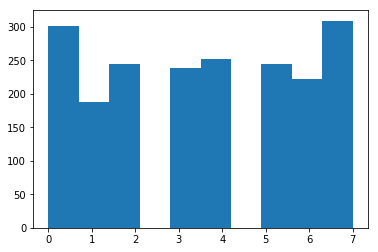

In [5]:
plt.hist(y_all)
plt.show()

In [6]:
from edward.models import RandomVariable
from tensorflow.contrib.distributions import Distribution

class NonTFOrdinalLogit(RandomVariable, Distribution):
    def __init__(self, logits, cutpoints, values=None):
        self._logits = logits
        self._cutpoints = cutpoints
        if values is None:
            values = range(len(cutpoints)+1)
        self.value_to_level = {v:l for l, v in enumerate(values)}

    def _data_size(self):
        return len(self._logits)
        
    def _cumul_probs(self):
        logits_with_cutpoints = self._logits[:,np.newaxis] + self._cutpoints  # using broadcasting
        return scipy.special.expit(logits_with_cutpoints)
        
    def _log_prob(self, value):
        cumul_probs = self._cumul_probs()
        level_probs = np.hstack([cumul_probs, np.ones((self._data_size(), 1))]) - \
                        np.hstack([np.zeros((self._data_size(), 1)), cumul_probs])
        levels = [self.value_to_level[v] for v in value]
        selected_probs = np.choose(levels, level_probs.T)
        return np.sum(np.log(selected_probs))

    def _sample_n(self, n, seed=None):
        cumul_probs = self._cumul_probs()
        
        def draw_one():
            sample_probs = np.random.uniform(size=(self._data_size(), 1))
            sample_y = (sample_probs > cumul_probs).astype(int).sum(axis=1)
            return sample_y
        
        return np.vstack([draw_one() for _ in range(n)])

In [7]:
n_cutpoints = 8
test_logits = np.random.randn(FLAGS.N)
test_cutpoints = np.linspace(0,1,n_cutpoints)

In [8]:
nontf_ol = NonTFOrdinalLogit(logits=test_logits, cutpoints=test_cutpoints)

In [9]:
nontf_ol._cumul_probs()

array([[0.65397389, 0.68555302, 0.7155039 , ..., 0.79426675, 0.81663238,
        0.83706539],
       [0.9107323 , 0.92168514, 0.93139535, ..., 0.95421336, 0.96006516,
        0.96519635],
       [0.74303756, 0.76935518, 0.79372567, ..., 0.85521492, 0.87202236,
        0.88713619],
       ...,
       [0.63383404, 0.66631334, 0.6972876 , ..., 0.77953974, 0.8031095 ,
        0.82472596],
       [0.47938332, 0.51508133, 0.55062611, ..., 0.65289119, 0.68452146,
        0.71452968],
       [0.15378634, 0.17330963, 0.19474103, ..., 0.27073002, 0.29983898,
        0.33065865]])

In [10]:
sample_n = 200
samples = nontf_ol._sample_n(sample_n)
samples

array([[0, 0, 0, ..., 0, 0, 8],
       [0, 0, 0, ..., 2, 7, 8],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 4, 0],
       [0, 0, 0, ..., 0, 8, 8],
       [0, 0, 0, ..., 8, 8, 0]])

In [11]:
nontf_ol._log_prob(samples[0])

-1273.6080842325514

In [12]:
from edward.models import RandomVariable
from tensorflow.python.framework import dtypes
from tensorflow.contrib.distributions import Distribution, NOT_REPARAMETERIZED

class distributions_OrdinalLogit(Distribution):
    def __init__(self, logits, cutpoints, name="OrdinalLogit"):
        self._logits = logits
        self._cutpoints = cutpoints
        
        parameters = dict(locals())
        super(distributions_OrdinalLogit, self).__init__(
            dtype=dtypes.int32,
            reparameterization_type=NOT_REPARAMETERIZED,
            validate_args=False,
            allow_nan_stats=True,
            parameters=parameters,
            graph_parents=[self._logits, self._cutpoints],
            name=name
        )

    def _data_size(self):
        return self._logits.shape[0].value
        
    def _cumul_probs(self):
        logits_with_cutpoints = tf.expand_dims(self._logits, -1) + self._cutpoints  # using broadcasting
        return tf.sigmoid(logits_with_cutpoints)
        
    def _log_prob(self, value):        
        cumul_probs = self._cumul_probs()
        level_probs = tf.concat([cumul_probs, tf.expand_dims(tf.ones([self._data_size()]), -1)], axis=1) - \
                        tf.concat([tf.expand_dims(tf.zeros([self._data_size()]), -1), cumul_probs], axis=1)
        levels = value
        indices_2d = tf.transpose(tf.stack([tf.range(self._data_size()), levels]))  # n x 2
        selected_probs = tf.gather_nd(level_probs, indices_2d)
        
        return tf.reduce_sum(tf.log(selected_probs))
    
    def _sample_n(self, n, seed=None):
        cumul_probs = self._cumul_probs()
        new_shape = tf.constant([n, self._data_size()])
        sample_probs = tf.expand_dims(tf.random_uniform(new_shape), -1)
        booleans = tf.greater(sample_probs, cumul_probs)  # using broadcasting
        samples = tf.reduce_sum(tf.cast(booleans, dtype=dtypes.int32), axis=-1)
        return samples
    
    def mean(self):
        # Using the identity that the mean is \sum_{i=0}^k P(X > i)
        cumul_probs = self._cumul_probs()
        means = tf.reduce_sum(1-cumul_probs, axis=1)
        return means
        

def __init__(self, *args, **kwargs):
    RandomVariable.__init__(self, *args, **kwargs)

_name = 'OrdinalLogit'
_candidate = distributions_OrdinalLogit
__init__.__doc__ = _candidate.__init__.__doc__
_globals = globals()
_params = {'__doc__': _candidate.__doc__,
           '__init__': __init__,
           'support': 'countable'}
_globals[_name] = type(_name, (RandomVariable, _candidate), _params)

In [13]:
# On some fake data, verify implementations of ordinal logit agree
logits = tf.placeholder(tf.float32, [FLAGS.N])
cutpoints = tf.placeholder(tf.float32, [n_cutpoints])

ol = OrdinalLogit(logits=logits, cutpoints=cutpoints)
with tf.Session() as sess:
    feed_dict = {logits: test_logits, cutpoints: test_cutpoints}
    cumul_probs2 = sess.run(ol._cumul_probs(), feed_dict=feed_dict)
    samples2 = sess.run(ol._sample_n(sample_n), feed_dict=feed_dict)
    first_sample = tf.cast(samples[0], dtypes.int32)
    logprob2 = sess.run(ol._log_prob(first_sample), feed_dict=feed_dict)

In [14]:
np.allclose(cumul_probs2, nontf_ol._cumul_probs())

True

In [15]:
np.allclose(logprob2, nontf_ol._log_prob(samples[0]))

True

/Users/cyz/edward/edward/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


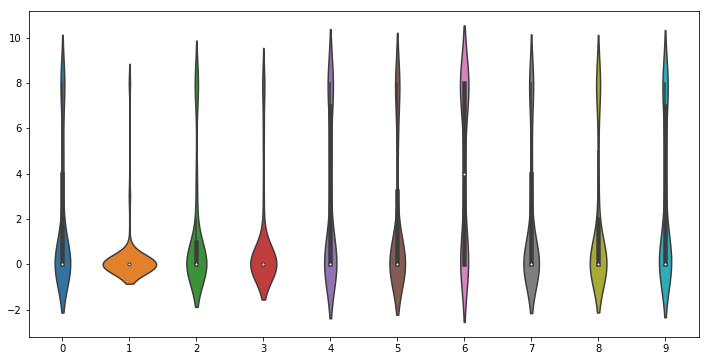

In [16]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (12, 6)
sns.violinplot(data=samples2[:,:10])

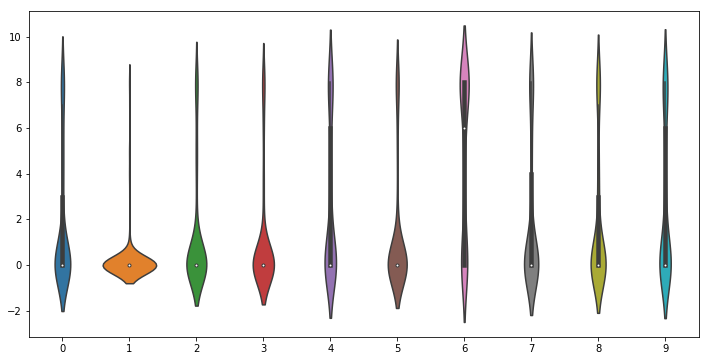

In [17]:
sns.violinplot(data=samples[:,:10])

In [19]:
X_train, X_rest, y_train, y_rest = train_test_split(X_all, y_all, train_size=FLAGS.N)

# MODEL
X = tf.placeholder(tf.float32, [FLAGS.N, FLAGS.D])
w = Normal(loc=tf.zeros(FLAGS.D), scale=tf.ones(FLAGS.D))
# b = Normal(loc=tf.zeros([1]), scale=tf.ones([1]))
# y = Bernoulli(logits=ed.dot(X, w) + b)

# define cutpoints from prior suggested by Carpenter
y = OrdinalLogit(logits=ed.dot(X, w), cutpoints=cutpoints)   # b gets absorbed into cutpoints

# INFERENCE
# qb = Normal(
#     loc=tf.Variable(tf.zeros([1])), 
#     scale=tf.Variable(tf.ones([1])))  # should probably initialize to random values

qw = MultivariateNormalTriL(
    loc=tf.Variable(tf.random_normal([FLAGS.D])),
    scale_tril=tf.Variable(tf.random_normal([FLAGS.D, FLAGS.D])))

# inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference = ed.Laplace({w: qw}, data={X: X_train, y: y_train, cutpoints: test_cutpoints})
inference.initialize(n_print=10, n_iter=600)

inference.run()


/Users/cyz/edward/edward/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 2951.881


In [20]:
# Hmm, is this due to bug or lack of prior on cutpoints?
# Replicate Bernoulli with OrdinalLogit...
# Wait, no error anymore!
# Should still replicate result with Bernoulli as a sanity check.

In [22]:
# these give same result
qw.scale.to_dense().eval()
tf.cholesky(qw.covariance()).eval()

array([[ 0.01378963,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.00059686,  0.01382207,  0.        ,  0.        ,  0.        ],
       [ 0.00151288,  0.00076892,  0.0141832 ,  0.        ,  0.        ],
       [ 0.00020055, -0.00050691, -0.0007917 ,  0.01408978,  0.        ],
       [-0.00060369,  0.00020785, -0.00021413, -0.0003165 ,  0.01398466]],
      dtype=float32)

In [23]:
# this is inverse of observed Fisher information, used in Laplace approximation
qw.covariance().eval()

array([[ 1.90153965e-04,  8.23054324e-06,  2.08620841e-05,
         2.76547166e-06, -8.32460046e-06],
       [ 8.23054324e-06,  1.91405852e-04,  1.15310340e-05,
        -6.88681575e-06,  2.51253005e-06],
       [ 2.08620841e-05,  1.15310340e-05,  2.04043201e-04,
        -1.13152755e-05, -3.79057292e-06],
       [ 2.76547166e-06, -6.88681575e-06, -1.13152755e-05,
         1.99445974e-04, -4.51628148e-06],
       [-8.32460046e-06,  2.51253005e-06, -3.79057315e-06,
        -4.51628148e-06,  1.96124238e-04]], dtype=float32)

In [24]:
qw.mean().eval()

array([ 0.05904175,  0.07664416,  0.14998022, -0.05155813,  0.01417927],
      dtype=float32)

In [25]:
# qb.scale.eval()

In [26]:
# qb.loc.eval()

In [27]:
obs_fisher = np.linalg.inv(qw.covariance().eval()) / FLAGS.N

In [28]:
print(obs_fisher)

[[ 5.337559   -0.20389518 -0.53609824 -0.10656545  0.21635236]
 [-0.20389518  5.256472   -0.26836634  0.16735534 -0.07732766]
 [-0.53609824 -0.26836634  4.988152    0.28305554  0.08360918]
 [-0.10656545  0.16735534  0.28305554  5.0398054   0.11485842]
 [ 0.21635236 -0.07732766  0.08360919  0.11485842  5.1132436 ]]


In [29]:
# y.log_prob requires argument of length y
# construct a new variable representing candidate from y_rest
# compute likelihood with autodiff

X = tf.placeholder(tf.float32, [1, FLAGS.D])
w = Normal(loc=tf.zeros(FLAGS.D), scale=tf.ones(FLAGS.D))
y = OrdinalLogit(logits=ed.dot(X, w), cutpoints=cutpoints)   # b gets absorbed into cutpoints

In [30]:
y_next = tf.get_variable("y_next", [1], dtype=dtypes.int32)

In [31]:
y_next_hess = tf.hessians(y.log_prob(y_next.value()), w)[0]

In [32]:
w_map = qw.mean().eval()

In [54]:
# verify the mean function works, but we won't be using it after all
for i in range(10):
    y_mean = y.mean().eval(feed_dict={X: X_train[[i]], w: w_map, cutpoints: test_cutpoints})[0]
    cumul_probs = y._cumul_probs().eval(feed_dict={X: X_train[[i]], w: w_map, cutpoints: test_cutpoints})[0]
    probs = np.append(cumul_probs, 1) - np.append(0, cumul_probs)
    brute_force_mean = (probs * np.arange(len(cumul_probs)+1)).sum()
    assert np.allclose(y_mean, brute_force_mean)

In [70]:
def new_point_info(X_new, y_new):
    return -y_next_hess.eval(feed_dict={X: X_new, w: w_map, cutpoints: test_cutpoints, y_next: y_new})

# TODO: make this more efficient (e.g. don't run all calls to new_point_info in separate sessions)
def new_point_info_expected(X_new):
    # integrate out y_next
    cumul_probs = y._cumul_probs().eval(feed_dict={X: X_new, w: w_map, cutpoints: test_cutpoints})[0]
    probs = np.append(cumul_probs, 1) - np.append(0, cumul_probs)
    levels = np.arange(probs.size)
    info_per_level = np.array([new_point_info(X_new, [level]) for level in levels])
    return probs[:,np.newaxis,np.newaxis] * info_per_level

## TODO: should initialize to the prior precision
obs_fisher_2 = np.zeros((FLAGS.D, FLAGS.D))
for i in range(len(X_train)):
    obs_fisher_2 += new_point_info(X_train[[i]], y_train[[i]])

In [71]:
obs_fisher_2 / FLAGS.N

array([[ 5.25789693, -0.22708986, -0.54864018, -0.11385049,  0.21941207],
       [-0.22708966,  5.24304887, -0.26007441,  0.17728381, -0.08771229],
       [-0.54864025, -0.2600744 ,  5.04271102,  0.28185857,  0.06379008],
       [-0.11385067,  0.17728379,  0.28185847,  5.06006064,  0.11130712],
       [ 0.2194122 , -0.08771193,  0.06378984,  0.11130714,  5.1265143 ]])

In [72]:
np.linalg.inv(obs_fisher)

array([[ 0.19015397,  0.00823054,  0.02086208,  0.00276547, -0.0083246 ],
       [ 0.00823054,  0.19140586,  0.01153103, -0.00688682,  0.00251253],
       [ 0.02086208,  0.01153103,  0.2040432 , -0.01131527, -0.00379057],
       [ 0.00276547, -0.00688682, -0.01131527,  0.19944596, -0.00451628],
       [-0.0083246 ,  0.00251253, -0.00379057, -0.00451628,  0.19612424]],
      dtype=float32)

In [73]:
np.round(np.linalg.inv(obs_fisher_2 / FLAGS.N) - np.linalg.inv(obs_fisher), 4)

array([[ 0.0031,  0.001 ,  0.0006,  0.0003, -0.0001],
       [ 0.001 ,  0.0006, -0.0003, -0.0003,  0.0004],
       [ 0.0006, -0.0003, -0.0022,  0.0002,  0.0008],
       [ 0.0003, -0.0003,  0.0002, -0.0008,  0.0001],
       [-0.0001,  0.0004,  0.0008,  0.0001, -0.0005]])

In [74]:
# Now let's implement item selection.

In [75]:
from collections import namedtuple

OptCriteria = namedtuple('OptCriteria', ['trace', 'logdet', 'max_eigval'])

# Lambda is the precision matrix
# return measures of the variance, Lambda^{-1}
def compute_opt_criteria(Lambda):
    eigvals_Lambda = np.linalg.eigvals(Lambda)
    # When there are not enough previous questions for full rank,
    # some eigenvalues will be 0. Ensure numerical stability here.
    # Originally chose threshold 1e-8, but sometimes an eigenvalue
    # that should've been 0 exceeded this threshold.
    # TODO: handle in a safer way.
    eigvals_Lambda[eigvals_Lambda < 1e-6] = 1e-6
    eigvals_Var = 1.0 / eigvals_Lambda
    return OptCriteria(
        trace = np.sum(eigvals_Var),
        logdet = np.sum(np.log(eigvals_Var)),
        max_eigval = np.max(eigvals_Var)
    )

opt_criteria_comparators = dict(
    A = lambda o1, o2: o1.trace - o2.trace,
    D = lambda o1, o2: o1.logdet - o2.logdet,
    E = lambda o1, o2: o1.max_eigval - o2.max_eigval
)

def cmp_criteria_for(optimality_type):
    return opt_criteria_comparators[optimality_type]


In [78]:
Lambda_prev = obs_fisher_2
best_new, best_opt_criteria = None, None
cmp_criteria = cmp_criteria_for('A')

for i in range(min(100, FLAGS.N)):
    X_cand = X_rest[[i]]
    Lambda_cand = Lambda_prev + new_point_info_expected(X_cand)
    opt_criteria = compute_opt_criteria(Lambda_cand)
    
    if best_opt_criteria is None or cmp_criteria(opt_criteria, best_opt_criteria) < 0:
        best_new = i
        best_opt_criteria = opt_criteria

In [79]:
best_new, X_rest[[best_new]], y_rest[[best_new]]

(16,
 array([[ 5.46072614,  3.85437939, -5.98121874,  1.63681644, -5.38637542]]),
 array([4]))